In [1]:
#ツイートのテキスト読み込み
test = open("RNN_tweet/extract_tweet.txt", "r", encoding="utf-8")
lines = test.readlines()
test.close()
print(len(lines))

#ラベル読み込み
test = open("RNN_tweet/label.txt", "r", encoding="utf-8")
label = test.readlines()
test.close()
print(len(label))

10000
10000


In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.utils.np_utils import to_categorical

maxlen = 100
training_samples = 8000 # training data 80 : validation data 20
validation_samples = len(lines) - training_samples
max_words = 20000

# word indexを作成
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)

word_index = tokenizer.word_index
print("Found {} unique tokens.".format(len(word_index)))

data = pad_sequences(sequences, maxlen=maxlen)

# バイナリの行列に変換
categorical_labels = to_categorical(label)
labels = np.asarray(categorical_labels)

print("Shape of data tensor:{}".format(data.shape))
print("Shape of label tensor:{}".format(labels.shape))

# 行列をランダムにシャッフルする
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Found 19411 unique tokens.
Shape of data tensor:(10000, 100)
Shape of label tensor:(10000, 2)


In [3]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.layers.core import Dropout

model = Sequential()
model.add(Embedding(20000, 100, input_length=maxlen))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

early_stopping = EarlyStopping(patience=0, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 2,080,602
Trainable params: 2,080,602
Non-trainable params: 0
_________________________________________________________________


In [4]:
history = model.fit(x_train, y_train, epochs=15, batch_size=250, validation_split=0.2, validation_data=(x_val, y_val), callbacks=[early_stopping])

Train on 8000 samples, validate on 2000 samples
Epoch 1/15
8000/8000 [==============================] - 45s 6ms/step - loss: 0.6371 - acc: 0.6414 - val_loss: 0.5729 - val_acc: 0.6450
Epoch 2/15
8000/8000 [==============================] - 40s 5ms/step - loss: 0.4829 - acc: 0.7561 - val_loss: 0.4810 - val_acc: 0.7675
Epoch 3/15
8000/8000 [==============================] - 42s 5ms/step - loss: 0.3173 - acc: 0.8709 - val_loss: 0.5014 - val_acc: 0.7770
Epoch 00003: early stopping


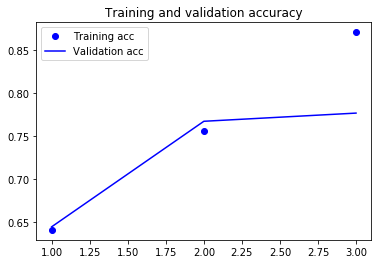

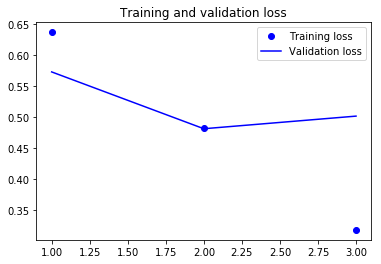

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()